# Omnigot One-Shot

In [1]:
import tensorflow as tf
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt

In [2]:
import vbranch
from vbranch.dataset import Omniglot

In [3]:
model_id = 5

## Load Data

In [4]:
if not os.path.isdir('./omniglot-images/images_background/'):
    with zipfile.ZipFile("./omniglot/python/images_background.zip","r") as zip_ref:
        zip_ref.extractall("omniglot-images")
        
if not os.path.isdir('./omniglot-images/images_evaluation/'):
    with zipfile.ZipFile("./omniglot/python/images_evaluation.zip","r") as zip_ref:
        zip_ref.extractall("omniglot-images")

In [5]:
train_generator = Omniglot('./omniglot-images/images_background/', 4, 4, 4, False)
test_generator = Omniglot('./omniglot-images/images_evaluation/', 4, 4, 4, False)

In [6]:
batch = next(train_generator)

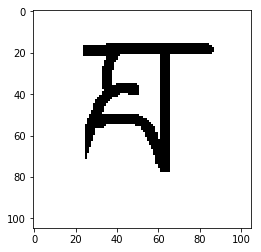

In [8]:
plt.imshow(batch[2, 3, 0], cmap=plt.cm.gray)
plt.show()

## Build Model

In [8]:
BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 100
model_path = './models/model_' + str(model_id)

In [9]:
tf.reset_default_graph()

train_data = (X_train_flat.astype('float32'), y_train_one_hot)
test_data = (X_test_flat.astype('float32'), y_test_one_hot)

batch_size = tf.placeholder('int64', name='batch_size')

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).\
    batch(batch_size).repeat().\
    shuffle(buffer_size=4*BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_data).\
    batch(batch_size).repeat()

iter_ = tf.data.Iterator.from_structure(train_dataset.output_types, 
                                       train_dataset.output_shapes)
inputs, labels_one_hot = iter_.get_next()

train_init_op = iter_.make_initializer(train_dataset)
test_init_op = iter_.make_initializer(test_dataset, name='test_init_op')

In [10]:
with tf.variable_scope('model_' + str(model_id)):
    outputs = vbranch.models.simple_fcnet(inputs, 128, num_classes)

In [11]:
tf.trainable_variables()

[<tf.Variable 'model_5/fc1_w:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'model_5/fc1_b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'model_5/bn1_scale:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'model_5/bn1_beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'model_5/fc2_w:0' shape=(128, 10) dtype=float32_ref>,
 <tf.Variable 'model_5/fc2_b:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'model_5/bn2_scale:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'model_5/bn2_beta:0' shape=(10,) dtype=float32_ref>]

In [12]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_one_hot, 
                                                                 logits=outputs), name='loss')
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
saver = tf.train.Saver()

In [13]:
pred = tf.nn.softmax(outputs, name='pred')
pred_max = tf.one_hot(tf.argmax(pred, axis=-1), num_classes)
acc = tf.reduce_mean(tf.reduce_sum(labels_one_hot*pred_max, [1]), name='acc')

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        sess.run(train_init_op, feed_dict={batch_size: BATCH_SIZE})

        for i in range(STEPS_PER_EPOCH):
            _, loss_value, acc_value = sess.run([train_op, loss, acc])
            
            if i == STEPS_PER_EPOCH - 1:
                sess.run(test_init_op, feed_dict={batch_size: len(X_test_flat)})
                val_loss, val_acc = sess.run([loss, acc])
                progbar.update(i + 1, values=[("loss", loss_value), ("acc", acc_value), 
                                              ("val_loss", val_loss), ("val_acc", val_acc)])
            else:
                progbar.update(i + 1, values=[("loss", loss_value), ("acc", acc_value)])
                
    path = os.path.join(model_path, 'ckpt')
    saver.save(sess, path)

Epoch 1/10
100/100 [==============================] - 11s 107ms/step - loss: 1.0735 - acc: 0.7894 - val_loss: 0.7641 - val_acc: 0.8916
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.7311 - acc: 0.8975 - val_loss: 0.6266 - val_acc: 0.9145
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6086 - acc: 0.9241 - val_loss: 0.5356 - val_acc: 0.9241
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5093 - acc: 0.9444 - val_loss: 0.4771 - val_acc: 0.9295
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4578 - acc: 0.9481 - val_loss: 0.4398 - val_acc: 0.9349
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3885 - acc: 0.9637 - val_loss: 0.3988 - val_acc: 0.9357
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3557 - acc: 0.9625 - val_loss: 0.3644 - val_acc: 0.9423
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss:

## Model Ensemble

In [15]:
test_pred = []
test_loss = []
test_acc = []

num_models = 5
graphs = [tf.Graph() for _ in range(num_models)]
sessions = [tf.Session(graph=g) for g in graphs]

for i in range(len(graphs)):
    with graphs[i].as_default():
        model_path = './models/model_' + str(i + 1)
        meta_path = os.path.join(model_path, 'ckpt.meta')
        ckpt = tf.train.get_checkpoint_state(model_path)
        
        imported_graph = tf.train.import_meta_graph(meta_path)
        imported_graph.restore(sessions[i], ckpt.model_checkpoint_path)
                
        sessions[i].run('test_init_op', feed_dict={'batch_size:0': len(X_test_flat)})
        
        pred, loss, acc = sessions[i].run(['pred:0', 'loss:0', 'acc:0'])
        test_pred.append(pred)
        test_loss.append(loss)
        test_acc.append(acc)

INFO:tensorflow:Restoring parameters from ./models/model_1/ckpt
INFO:tensorflow:Restoring parameters from ./models/model_2/ckpt
INFO:tensorflow:Restoring parameters from ./models/model_3/ckpt
INFO:tensorflow:Restoring parameters from ./models/model_4/ckpt
INFO:tensorflow:Restoring parameters from ./models/model_5/ckpt


In [16]:
test_acc

[0.9435, 0.9438, 0.9419, 0.942, 0.94]

In [17]:
def compute_acc(pred, labels_one_hot):
    pred_max = tf.keras.utils.to_categorical(np.argmax(pred, axis=-1), num_classes)
    return np.mean(np.sum(labels_one_hot*pred_max, axis=1))

In [21]:
for i in range(num_models):
    assert compute_acc(test_pred[i], y_test_one_hot) == test_acc[i]

In [19]:
pred_avg = np.mean(test_pred, axis=0)
print(compute_acc(pred_avg, y_test_one_hot))

0.9522
